# Aplicando Redes Neurais Multilayer Perceptron (MLP) com PyTorch

## Bibliotecas

In [1]:
# Importando os pacotes necessários

# comandos para plotar imagens mais bem definidas no notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

# Algumas funções auxiliares
import helper

import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets, transforms

## Importando a amostra de treino

In [3]:
# Define a transformação dos dados. 
# Note que nesse caso joga um valor médio de 0.5 e desvio de 0.5, normalizando os valores entre -1 e 1.
# (https://discuss.pytorch.org/t/understanding-transform-normalize/21730)
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

## Construindo a rede neural

In [4]:
import torch.nn.functional as F
from torch import nn

In [5]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Camada escondida 1 (128 neuronônios)
        self.fc1 = nn.Linear(784, 128)
        # Camada escondida 1 (128 neuronônios)
        self.fc2 = nn.Linear(128, 64)
        # Camada de saíada (10 unidades)
        self.output = nn.Linear(64, 10)
        
    def forward(self, x):
        # Camada escondida 1 com ativação ReLU
        x = F.relu(self.fc1(x))
        # Camada escondida 2 com ativação ReLU
        x = F.relu(self.fc2(x))
        # Camada escondida com ativação Softmax 
        x = F.softmax(self.output(x), dim=1)
        
        return x

In [6]:
# Visualização da rede
model = MyNN()
model

MyNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

## Treinando a rede

In [7]:
from torch import optim

In [8]:
# O modelo
model = nn.Sequential(nn.Linear(784, 128),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64, 10),
                     nn.LogSoftmax(dim=1))

# Definição do critério (negative log likelihood)
criterion = nn.NLLLoss()

# Definição do atualizador (gradiente descendente estocástico)
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 5
for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Achatando as imagens do MNIST em um vetor de comprimento 784
        images = images.view(images.shape[0], -1)
    
        # Etapa de treinamento
        optimizer.zero_grad()
        
        # Passagens forward, backward, e atualização dos pesos
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.0453211156004019
Training loss: 0.3822509984869057
Training loss: 0.3228877586548898
Training loss: 0.29222924460861477
Training loss: 0.26809915578536897


### Vizualizando a rede treinada

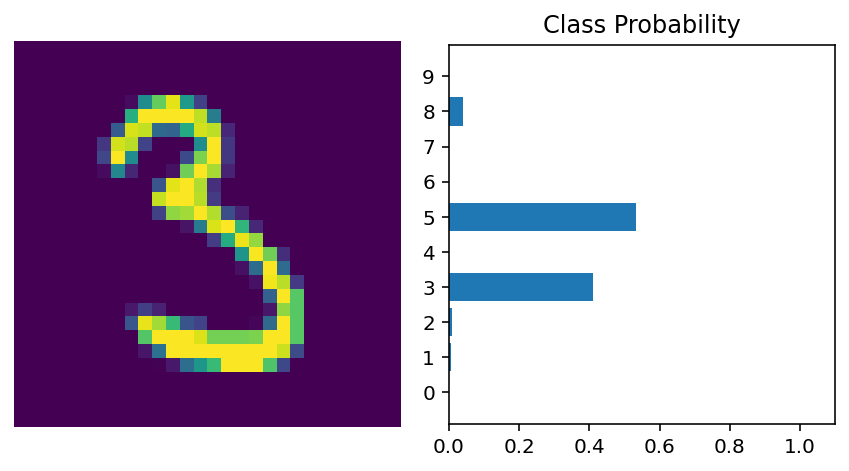

In [9]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# desligando o gradiente para acelerar o processo
with torch.no_grad():
    logps = model(img)

# As saidas da rede são o log da probabilidade.
# Por isso precisamos fazer o exponencial para termos as probabilidades reais.
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

## Testando a rede

### Importando a amostra de teste

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
test_dataset = datasets.MNIST('~/data', download=True, train=False, transform=transform)
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: /home/luis/data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [11]:
import pandas as pd
from torch.autograd import Variable

### Estimando os rótulos das amostras de teste

In [12]:
predicted = []
expected = []

for image, label in test_dataset:
    image = Variable(image.view(-1, 28*28))
    outputs = model(image)
    _, prediction = torch.max(outputs.data, 1)
    predicted.append(prediction.item())
    expected.append(label)

In [13]:
results = pd.DataFrame({'predicted': predicted, 'expected':expected})
results

,predicted,expected
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
9995,2,2
9996,3,3
9997,4,4
9998,5,5


## Avaliando o modelo

### Acurácia

In [14]:
accuracy = (results['predicted'] == results['expected']).sum()/len(results)
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.9289


### Matriz de confusão

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

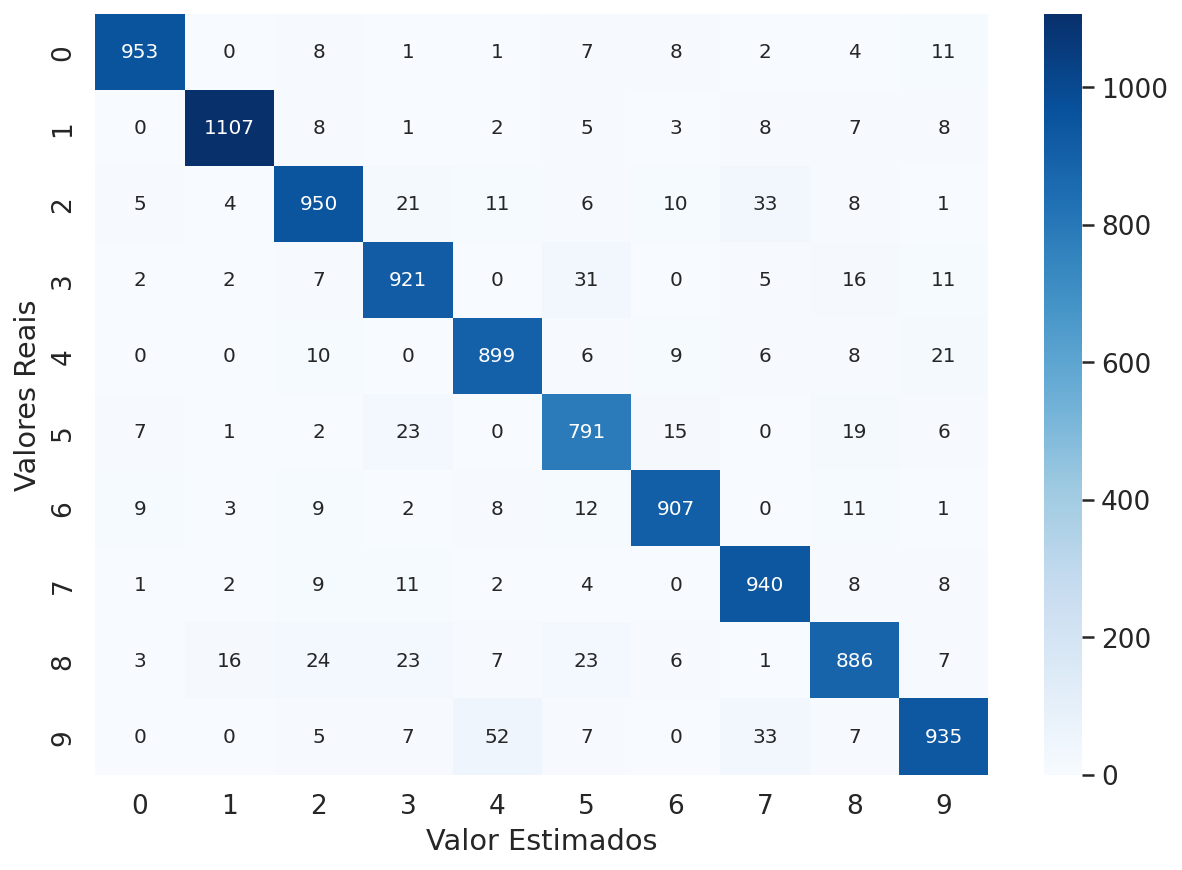

In [16]:
cm = confusion_matrix(predicted, expected)
df_cm = pd.DataFrame(cm)
df_cm.index.name = "Valores Reais"
df_cm.columns.name = "Valor Estimados"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()